In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


## Import library

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import cv2
import json, os, sys

from tensorflow.keras.utils import img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Flatten, Dense
from keras.applications.mobilenet import MobileNet, preprocess_input 
from keras.losses import categorical_crossentropy
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing import image


In [2]:
!unzip '/gdrive/MyDrive/CS231.M21.KHCL/NopBaoCaoDoAn/20520934 + 20521384/Dataset FER2013/FER_13.zip'

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

## Prepare training data

In [ ]:
train_datagen = ImageDataGenerator(
    horizontal_flip=True, 
    rescale = 1./255
)

train_data = train_datagen.flow_from_directory(directory= "train", 
                                               target_size=(48,48), 
                                               batch_size=32,
                                               color_mode="grayscale",
                                               class_mode='categorical'
)

train_data.class_indices

Found 28709 images belonging to 7 classes.


{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

## Prepare validation data

In [ ]:
val_datagen = ImageDataGenerator(rescale = 1./255 )

val_data = val_datagen.flow_from_directory(directory= "test", 
                                           target_size=(48,48), 
                                           batch_size=32,
                                           color_mode="grayscale",
                                           class_mode='categorical'
)

Found 7178 images belonging to 7 classes.


## Build model

In [ ]:
def build_model(emotion_model):
    ''' First model '''
    emotion_model.add(Conv2D(filters=64,kernel_size=(5,5),input_shape=(48, 48, 1),activation='relu',padding='same',kernel_initializer='he_normal'))
    emotion_model.add(BatchNormalization())
    emotion_model.add(Conv2D(filters=64,kernel_size=(5,5),activation='relu',padding='same',kernel_initializer='he_normal'))
    emotion_model.add(BatchNormalization())
    emotion_model.add(MaxPooling2D(pool_size=(2,2)))
    emotion_model.add(Dropout(0.5))

    ''' Second layer '''
    emotion_model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same',kernel_initializer='he_normal'))
    emotion_model.add(BatchNormalization())
    emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
    emotion_model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same',kernel_initializer='he_normal'))
    emotion_model.add(BatchNormalization())
    emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
    emotion_model.add(Dropout(0.5))

    '''Extra layer'''
    emotion_model.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same',kernel_initializer='he_normal'))
    emotion_model.add(BatchNormalization())
    emotion_model.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same',kernel_initializer='he_normal'))
    emotion_model.add(BatchNormalization())
    emotion_model.add(MaxPooling2D(pool_size=(2,2)))
    emotion_model.add(Dropout(0.5))

    '''Fully connected layer'''
    emotion_model.add(Flatten())
    emotion_model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
    emotion_model.add(Dropout(0.6))
    emotion_model.add(Dense(7, activation='softmax'))

    cv2.ocl.setUseOpenCL(False)

    emotion_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3, decay=1e-6), metrics=['accuracy'])

    return emotion_model

## Build early stopping

In [ ]:
''' Callbacks '''
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    ModelCheckpoint('E:\\Practice Introduction to Computer Vision\\EmotionalFaceRecognition_2\\model\\best_model.h5', save_best_only=False, verbose=0),
    early_stopping,
    lr_scheduler,
]

## Initialize model and train model

In [ ]:
emotion_model = Sequential(name='DCNN')
emotion_model = build_model(emotion_model)

emotion_model.summary()

hist = emotion_model.fit(train_data,
                        callbacks=callbacks,
                        batch_size=32,
                        epochs=500,
                        verbose=1,
                        validation_data=val_data,
                        shuffle=True)

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1664      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                              

c:\Users\ASUS ROG ZEPHYRUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/500
898/898 [==============================] - 459s 510ms/step - loss: 1.9161 - accuracy: 0.2456 - val_loss: 1.8119 - val_accuracy: 0.2473 - lr: 0.0010
Epoch 2/500
898/898 [==============================] - 420s 468ms/step - loss: 1.8135 - accuracy: 0.2511 - val_loss: 1.7796 - val_accuracy: 0.2471 - lr: 0.0010
Epoch 3/500
898/898 [==============================] - 398s 443ms/step - loss: 1.7842 - accuracy: 0.2513 - val_loss: 1.7093 - val_accuracy: 0.2471 - lr: 0.0010
Epoch 4/500
898/898 [==============================] - 396s 441ms/step - loss: 1.7655 - accuracy: 0.2512 - val_loss: 1.7074 - val_accuracy: 0.2471 - lr: 0.0010
Epoch 5/500
898/898 [==============================] - 399s 444ms/step - loss: 1.7577 - accuracy: 0.2513 - val_loss: 1.6561 - val_accuracy: 0.2471 - lr: 0.0010
Epoch 6/500
898/898 [==============================] - 390s 434ms/step - loss: 1.7494 - accuracy: 0.2512 - val_loss: 1.7540 - val_accuracy: 0.2471 - lr: 0.0010
Epoch 7/500
898/898 [===================

In [ ]:
# save model structure in jason file
model_json = emotion_model.to_json()
with open("E:\\Practice Introduction to Computer Vision\\EmotionalFaceRecognition_2\\model\\best_face_model.json", "w") as json_file:
    json_file.write(model_json)

# save trained model weight in .h5 file
emotion_model.save_weights('E:\\Practice Introduction to Computer Vision\\EmotionalFaceRecognition_2\\model\\best_model.h5')

In [ ]:
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

In [ ]:
predictions = emotion_model.predict_generator(val_data)

C:\Users\ASUS ROG ZEPHYRUS\AppData\Local\Temp\ipykernel_6372\1516356448.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = emotion_model.predict_generator(val_data)


-----------------------------------------------------------------
[[110  18 108 246 206 182  88]
 [  8   3  14  35  22  18  11]
 [137  15 115 243 217 189 108]
 [254  33 186 407 392 288 214]
 [139  14 129 305 298 219 129]
 [120  21 142 326 294 223 121]
 [105  13  86 196 185 164  82]]


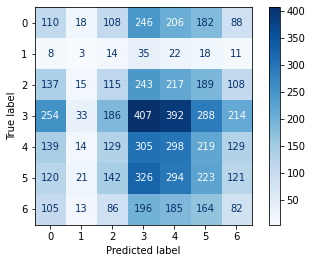

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.13      0.11      0.12       958
           1       0.03      0.03      0.03       111
           2       0.15      0.11      0.13      1024
           3       0.23      0.23      0.23      1774
           4       0.18      0.24      0.21      1233
           5       0.17      0.18      0.18      1247
           6       0.11      0.10      0.10       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



In [ ]:
print("-----------------------------------------------------------------")
# confusion matrix
c_matrix = confusion_matrix(val_data.classes, predictions.argmax(axis=1))
print(c_matrix)
cm_display = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=emotion_dict)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

# Classification report
print("-----------------------------------------------------------------")
print(classification_report(val_data.classes, predictions.argmax(axis=1)))

In [ ]:
h =  hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

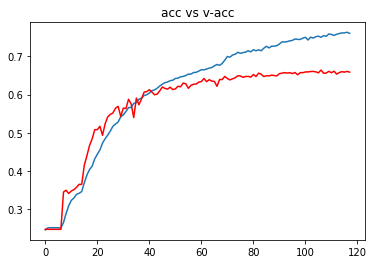

In [ ]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'] , c = "red")
plt.title("acc vs v-acc")
plt.show()

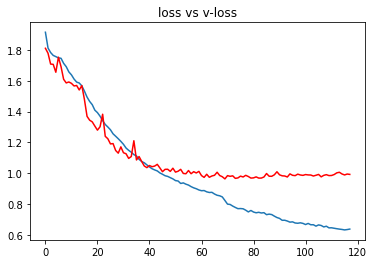

In [ ]:
plt.plot(h['loss'])
plt.plot(h['val_loss'] , c = "red")
plt.title("loss vs v-loss")
plt.show()

## Testing

1/1 [==============================] - 0s 127ms/step
 the image is of Disgusted


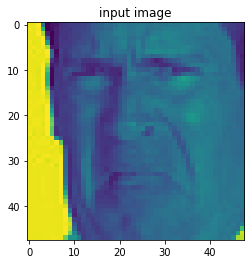

In [ ]:
# path for the image to see if it predics correct class

path = "E:\\Practice Introduction to Computer Vision\EmotionalFaceRecognition_2\\test\\disgust\\PrivateTest_807646.jpg"
img = load_img(path, target_size=(48, 48), color_mode='grayscale')

i = img_to_array(img)/255
input_arr = np.array([i])
input_arr.shape

trained_model = model_from_json(open("E:\\Practice Introduction to Computer Vision\\EmotionalFaceRecognition_2\\model\\best_face_model.json", "r").read())

trained_model.load_weights('E:\\Practice Introduction to Computer Vision\\EmotionalFaceRecognition_2\\model\\best_model.h5')

emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

pred = np.argmax(trained_model.predict(input_arr))

print(f" the image is of {emotion_dict[pred]}")

# to display the image  
plt.imshow(input_arr[0])
plt.title("input image")
plt.show()